## Adaptive Learning Rate via RMSProp


Basically the main idea is divide the learning rate by an exponentially decreasing moving avg of the squared gradients

In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import grad
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('/content/linreg-data.csv', index_col=0)

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

torch.manual_seed(123)

shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)

X=X[shuffle_idx]
y=y[shuffle_idx]

percent70=int(X.shape[0]*0.7)

X_train=X[:percent70]
y_train=y[:percent70]

X_test=X[percent70:]
y_test=y[percent70:]

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

 Below is an implementation of Linear Regression where we have used normal SGD


In [3]:
class LinearRegression01(torch.nn.Module):

  def __init__(self,num_features):
    super(LinearRegression01, self).__init__()
    self.linear = torch.nn.Linear(num_features, 1)


    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()


  def forward(self,X):

    return self.linear(X).reshape(-1)

  def train(self,X,y,epochs,lr=0.01,minibatch_size=10):

    torch.manual_seed(120)
    loss=[]
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)

    for epoch in range(epochs):
      shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)
      minibatch_indices=torch.split(shuffle_idx,minibatch_size)
      for minibatch_idx in minibatch_indices:
        y_pred=self.forward(X[minibatch_idx])
        mse=F.mse_loss(y_pred, y[minibatch_idx])

        optimizer.zero_grad()
        mse.backward()
        optimizer.step()

      with torch.no_grad():

        preds=self.forward(X)
        curr_loss=torch.mean((y-preds)**2)
        print(f'Epoch: {epoch+1}, Loss: {curr_loss}')
        loss.append(curr_loss)
    return loss

## Below is an implementation of Linear Regression with RMSprop


In simple terms, RMSprop adapts the learning rate for each parameter, reducing the learning rate for parameters with larger gradients and increasing it for those with smaller gradients. This helps to stabilize training and prevent overshooting.

### Key Concepts:
- **mean_square_w** and **mean_square_b** are the **mean squared gradients** for the weights and bias. These terms accumulate the squared gradients over time, helping to scale the updates.
  
- **beta** is the **decay factor**, which controls the weighting of past squared gradients. The larger the beta, the slower the decay, which means the algorithm retains more information from previous gradients.

- **epsilon** is a small constant added for numerical stability to avoid division by zero when normalizing the gradients.

### Equations:
1. **Mean Squared Gradient Update**:

   mean_square_w = beta * mean_square_w + (1 - beta) * (grad_w^2)  
   mean_square_b = beta * mean_square_b + (1 - beta) * (grad_b^2)  

   Where:
   - mean_square_w, mean_square_b are the running averages of the squared gradients for the weights and bias.
   - beta is the decay factor.
   - grad_w, grad_b are the gradients of the loss with respect to weights and bias.

2. **Parameter Update**:

   w = w - lr * grad_w / sqrt(mean_square_w + epsilon)  
   b = b - lr * grad_b / sqrt(mean_square_b + epsilon)  

   Where:
   - w, b are the weight and bias parameters.
   - lr is the learning rate.
   - epsilon is a small constant added for numerical stability.

In [4]:
class LinearRegression02(torch.nn.Module):

  def __init__(self,num_features):
    super(LinearRegression02, self).__init__()
    self.linear = torch.nn.Linear(num_features, 1)

    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()


  def forward(self,X):

    return self.linear(X).reshape(-1)

  def train(self,X,y,epochs,lr=0.01,minibatch_size=10,beta=0.9):
    torch.manual_seed(120)
    loss=[]
    epsilon=1e-10

    mean_square_w=torch.zeros_like(self.linear.weight)
    mean_square_b=torch.zeros_like(self.linear.bias)
    for epoch in range(epochs):
      shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)
      minibatch_indices=torch.split(shuffle_idx,minibatch_size)
      for minibatch_idx in minibatch_indices:
        y_pred=self.forward(X[minibatch_idx])
        mse=F.mse_loss(y_pred, y[minibatch_idx])
        grad_w=grad(mse,self.linear.weight,retain_graph=True)[0]
        grad_b=grad(mse,self.linear.bias)[0]

        mean_square_w=beta*mean_square_w+(1-beta)*(grad_w**2)
        mean_square_b=beta*mean_square_b+(1-beta)*(grad_b**2)

        with torch.no_grad():
          self.linear.weight-=lr*grad_w/torch.sqrt(mean_square_w+epsilon)
          self.linear.bias-=lr*grad_b/torch.sqrt(mean_square_b+epsilon)

      with torch.no_grad():
        preds=self.forward(X)
        epoch_loss=F.mse_loss(preds, y)
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss}')
        loss.append(epoch_loss)
    return loss






In [5]:
linear_regression=LinearRegression01(num_features=X.shape[1])
loss_without_rmsprop=linear_regression.train(X_train,y_train,100,lr=0.01)

Epoch: 1, Loss: 472.7065734863281
Epoch: 2, Loss: 388.48199462890625
Epoch: 3, Loss: 384.5899963378906
Epoch: 4, Loss: 384.4708557128906
Epoch: 5, Loss: 384.50311279296875
Epoch: 6, Loss: 384.38348388671875
Epoch: 7, Loss: 384.35626220703125
Epoch: 8, Loss: 384.7010192871094
Epoch: 9, Loss: 384.4432678222656
Epoch: 10, Loss: 384.4690246582031
Epoch: 11, Loss: 384.48358154296875
Epoch: 12, Loss: 384.4710388183594
Epoch: 13, Loss: 384.39892578125
Epoch: 14, Loss: 384.427490234375
Epoch: 15, Loss: 384.5412902832031
Epoch: 16, Loss: 384.3504943847656
Epoch: 17, Loss: 384.3441467285156
Epoch: 18, Loss: 384.38262939453125
Epoch: 19, Loss: 384.57110595703125
Epoch: 20, Loss: 384.4284973144531
Epoch: 21, Loss: 384.5216979980469
Epoch: 22, Loss: 384.5309753417969
Epoch: 23, Loss: 384.79119873046875
Epoch: 24, Loss: 384.43328857421875
Epoch: 25, Loss: 384.3867492675781
Epoch: 26, Loss: 384.6307067871094
Epoch: 27, Loss: 384.42572021484375
Epoch: 28, Loss: 384.56976318359375
Epoch: 29, Loss: 384.

In [8]:
linear_regression_with_rmsprop=LinearRegression02(num_features=X.shape[1])
loss_with_rmsprop=linear_regression_with_rmsprop.train(X_train,y_train,100)

Epoch: 1, Loss: 1926.3935546875
Epoch: 2, Loss: 1878.8282470703125
Epoch: 3, Loss: 1830.2198486328125
Epoch: 4, Loss: 1782.9139404296875
Epoch: 5, Loss: 1735.8760986328125
Epoch: 6, Loss: 1691.0323486328125
Epoch: 7, Loss: 1645.859130859375
Epoch: 8, Loss: 1601.2843017578125
Epoch: 9, Loss: 1557.377685546875
Epoch: 10, Loss: 1516.15234375
Epoch: 11, Loss: 1474.5003662109375
Epoch: 12, Loss: 1433.705078125
Epoch: 13, Loss: 1392.3021240234375
Epoch: 14, Loss: 1354.403076171875
Epoch: 15, Loss: 1314.462158203125
Epoch: 16, Loss: 1278.698974609375
Epoch: 17, Loss: 1241.3746337890625
Epoch: 18, Loss: 1205.541015625
Epoch: 19, Loss: 1170.593505859375
Epoch: 20, Loss: 1135.8751220703125
Epoch: 21, Loss: 1101.0838623046875
Epoch: 22, Loss: 1068.6778564453125
Epoch: 23, Loss: 1036.313720703125
Epoch: 24, Loss: 1005.7125244140625
Epoch: 25, Loss: 974.63330078125
Epoch: 26, Loss: 946.4483642578125
Epoch: 27, Loss: 917.8948364257812
Epoch: 28, Loss: 889.963134765625
Epoch: 29, Loss: 862.0158081054

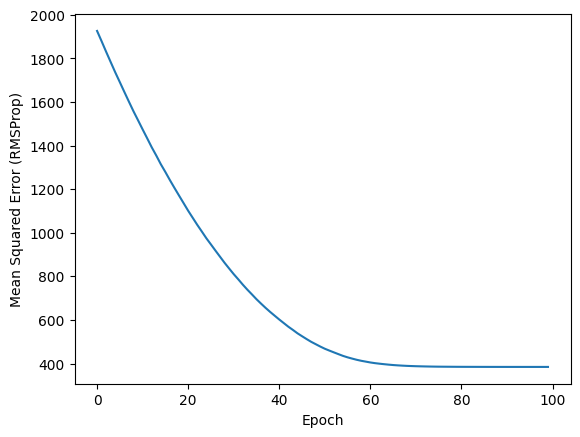

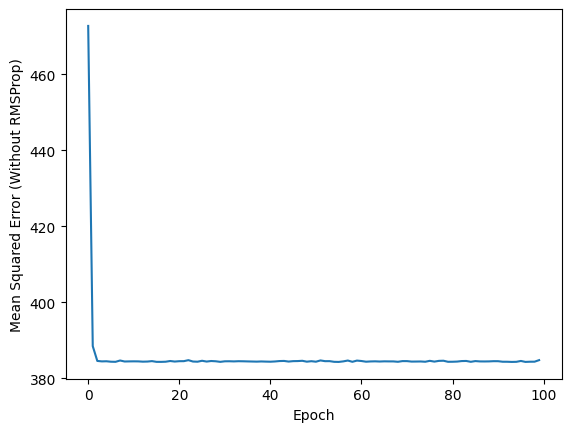

In [9]:
plt.plot(range(len(loss_with_rmsprop)), loss_with_rmsprop)
plt.ylabel('Mean Squared Error (RMSProp)')
plt.xlabel('Epoch')
plt.show()



plt.plot(range(len(loss_without_rmsprop)), loss_without_rmsprop)
plt.ylabel('Mean Squared Error (Without RMSProp)')
plt.xlabel('Epoch')
plt.show()